In [25]:
import tensorflow as t
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt

# Importar dependencias para el modelo
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# Importar dependencias para guardar el modelo
from tensorflow.python.keras.models import save_model, load_model

In [26]:
data_dir = 'data-adversarial-training'

# Mostrar una imagen con matplotlib usando cv2 para corregir los colores
def mostrarImagen(img: cv2.typing.MatLike):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [27]:
datos = t.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=32,  # Tamaño de lote de datos
)
# Creamos un iterador para recorrer los datos
iterador_datos = datos.as_numpy_iterator()
lote_datos = iterador_datos.next() # Si tenemos error implica que las imágenes tienen formatos incorrectos.

Found 693 files belonging to 4 classes.


In [28]:
lote_datos # (imagenes, etiquetas)

(array([[[[0.00000000e+00, 1.00000000e+00, 1.30000000e+01],
          [6.00000000e+00, 1.20000000e+01, 2.60000000e+01],
          [0.00000000e+00, 6.00000000e+00, 2.50000000e+01],
          ...,
          [1.00000000e+01, 1.20000000e+01, 0.00000000e+00],
          [1.00000000e+00, 3.00000000e+00, 2.00000000e+00],
          [0.00000000e+00, 1.00000000e+00, 4.00000000e+00]],
 
         [[0.00000000e+00, 5.00000000e+00, 1.40000000e+01],
          [1.17000000e+02, 1.29000000e+02, 1.43000000e+02],
          [1.06000000e+02, 1.22000000e+02, 1.47000000e+02],
          ...,
          [1.66000000e+02, 1.67000000e+02, 1.59000000e+02],
          [1.76000000e+02, 1.78000000e+02, 1.77000000e+02],
          [1.76000000e+02, 1.80000000e+02, 1.83000000e+02]],
 
         [[0.00000000e+00, 2.00000000e+01, 2.10000000e+01],
          [1.79000000e+02, 2.02000000e+02, 2.16000000e+02],
          [9.70000000e+01, 1.29000000e+02, 1.67000000e+02],
          ...,
          [2.32000000e+02, 2.32000000e+02, 2.3200

In [29]:
# Diccionario de etiquetas
nombre_etiqueta = {
    0: 'Señal Máx. 120Km/h',
    1: 'Señal Máx. 50Km/h',
    2: 'Señal Radar',
    3: 'Señal STOP'
}

def mostrarPrediccion(yhat: np.ndarray,img):

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Prediccion: {}'.format(nombre_etiqueta[np.argmax(yhat)]))
    plt.show()

In [30]:
datos = datos.map(lambda x,y: (x/255, y))

In [31]:
iterador_datos = datos.as_numpy_iterator()
lote_datos = iterador_datos.next()

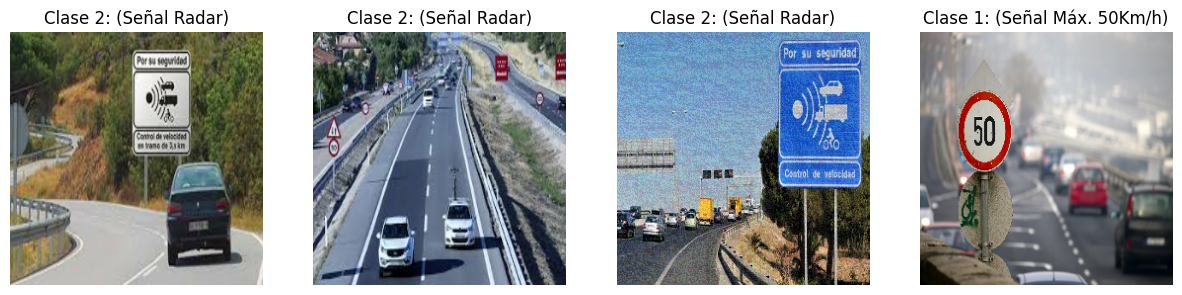

In [32]:
# Mostrar las clases de las imágenes con ejemplo
fig, axs = plt.subplots(1, 4, figsize=(15, 15),sharey=True)
for idx,img in enumerate(lote_datos[0][:4]):
    axs[idx].imshow(img)
    clase = lote_datos[1][idx]
    axs[idx].set_title('Clase {}: ({})'.format(clase,nombre_etiqueta[clase]))
    axs[idx].axis('off')

In [33]:
size_entrenamiento = int(len(datos) * 0.7)
size_validacion = int(len(datos) * 0.15) + 1
size_test = int(len(datos) * 0.15) + 1

#len(datos) == size_entrenamiento + size_validacion + size_test

In [34]:
particion_entrenamiento = datos.take(size_entrenamiento)
particion_validacion = datos.skip(size_entrenamiento).take(size_validacion)
particion_test = datos.skip(size_entrenamiento + size_validacion)

In [35]:
modelo  = Sequential() # Inicializar el modelo

In [36]:
modelo.add(Conv2D(16, (3, 3),1 , activation='relu', input_shape=(256, 256, 3))) # Capa de convolución
modelo.add(MaxPooling2D()) # Capa de pooling

modelo.add(Conv2D(32, (3, 3),1 , activation='relu')) # Capa de convolución
modelo.add(MaxPooling2D()) # Capa de pooling

modelo.add(Conv2D(16, (3, 3),1 , activation='relu')) # Capa de convolución
modelo.add(MaxPooling2D()) # Capa de pooling

modelo.add(Flatten()) # Aplanar la imagen

modelo.add(Dense(256, activation='relu')) # Capa densa
modelo.add(Dense(4, activation='softmax')) # Capa densa

In [37]:
# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Ver las estadísticas del modelo generado
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)            

In [39]:
# Seleccionar directorio para guardar los logs
logs_dir = 'logs-adversarial-training'
tensorboard_callback = t.keras.callbacks.TensorBoard(log_dir=logs_dir, histogram_freq=1)

In [40]:
# Entrenar el modelo y guardar los logs
hist = modelo.fit(particion_entrenamiento, validation_data=particion_validacion, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
15/15 [==============================] - 11s 630ms/step - loss: 1.7380 - accuracy: 0.3375 - val_loss: 1.2050 - val_accuracy: 0.4609
Epoch 2/20
15/15 [==============================] - 8s 528ms/step - loss: 1.1480 - accuracy: 0.5583 - val_loss: 0.8370 - val_accuracy: 0.6641
Epoch 3/20
15/15 [==============================] - 8s 526ms/step - loss: 0.8597 - accuracy: 0.6667 - val_loss: 0.6707 - val_accuracy: 0.7578
Epoch 4/20
15/15 [==============================] - 10s 618ms/step - loss: 0.6545 - accuracy: 0.7812 - val_loss: 0.5302 - val_accuracy: 0.8750
Epoch 5/20
15/15 [==============================] - 9s 589ms/step - loss: 0.3757 - accuracy: 0.8792 - val_loss: 0.2425 - val_accuracy: 0.9297
Epoch 6/20
15/15 [==============================] - 10s 588ms/step - loss: 0.2479 - accuracy: 0.9125 - val_loss: 0.1965 - val_accuracy: 0.9453
Epoch 7/20
15/15 [==============================] - 10s 654ms/step - loss: 0.1522 - accuracy: 0.9708 - val_loss: 0.0799 - val_accuracy: 0.9844
Ep

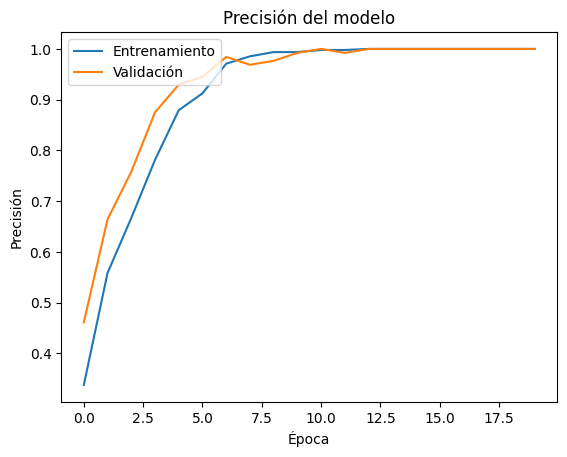

In [41]:
# Evaluar la precisión del modelo
fig = plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

In [42]:
modelo.save(os.path.join('models','SignAdversaryTrainedClassifier.h5'))